# 27.2.2 Ultimate Technologies Inc. Take-Home Challenge
Ultimate Technologies Inc. is a transportation network company that has disrupted the taxi and logistics industry and is considered a prestigious company to work for. This challenge has been adapted from an actual Ultimate Inc. data science challenge.

## Part 1 ‐ Exploratory data analysis
The attached `logins.json` file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15-minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [123]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm # linear regression
import seaborn as sns # correlation matrix
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score # train-test
import os
os.chdir('C:/Sereda/Lectures/Springboard/27.Effective_Interviewing_for_Data_Scientists/ultimate_challenge')

In [152]:
# Load *.json file
with open('logins.json', 'r') as json_file:
    ts = pd.DataFrame(json.load(json_file)) # Time series (column of timestamp strings)
ts = pd.to_datetime(ts['login_time']) # convert strings to timestamps
print("Earliest login:\t", min(ts))
print("Latest login:\t", max(ts))

Earliest login:	 1970-01-01 20:12:16
Latest login:	 1970-04-13 18:57:38


Timestamps are not sorted:

In [153]:
ts[2]

Timestamp('1970-01-01 20:16:37')

In [154]:
ts[3]

Timestamp('1970-01-01 20:16:36')

In [155]:
# Resample using 15-min periods
df = ts.to_frame()
df.set_index('login_time', inplace = True)
df['count'] = 1
df = df.resample('15T').sum()
df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [156]:
ts.head()

0   1970-01-01 20:13:18
1   1970-01-01 20:16:10
2   1970-01-01 20:16:37
3   1970-01-01 20:16:36
4   1970-01-01 20:26:21
Name: login_time, dtype: datetime64[ns]

In [157]:
# Verification of resampling
ts[ts < pd.Timestamp('1970-01-01 20:15:00')] # 1st period

0   1970-01-01 20:13:18
6   1970-01-01 20:12:16
Name: login_time, dtype: datetime64[ns]

In [158]:
ts[(pd.Timestamp('1970-01-01 20:15:00') <= ts) & (ts < pd.Timestamp('1970-01-01 20:30:00'))] # 2nd period

1    1970-01-01 20:16:10
2    1970-01-01 20:16:37
3    1970-01-01 20:16:36
4    1970-01-01 20:26:21
5    1970-01-01 20:21:41
10   1970-01-01 20:26:05
Name: login_time, dtype: datetime64[ns]

In [181]:
df.sum()[0] == len(ts) # sum of counts

True

In [182]:
# Descriptive statistics of login counts
df.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [188]:
df['count']

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Freq: 15T, Name: count, Length: 9788, dtype: int64

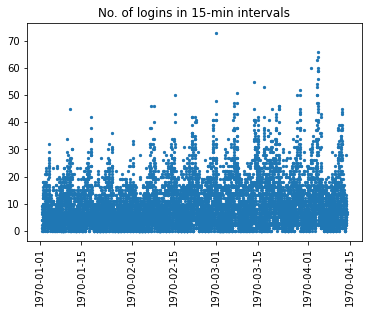

In [198]:
plt.title('No. of logins in 15-min intervals')
plt.scatter(x=df.index, y=df['count'], s=5)
plt.xticks(rotation = 90);

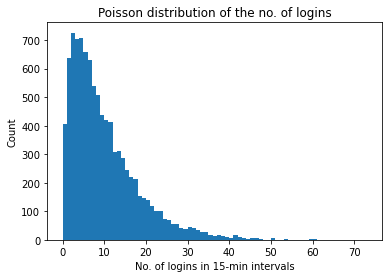

In [260]:
plt.title("Poisson distribution of the no. of logins")
Hist, x, _ = plt.hist(df, bins=df['count'].max())
plt.xlabel('No. of logins in 15-min intervals')
plt.ylabel('Count');

Let's find out the parameters of the distribution.

In [299]:
def pois(l,x):
    return math.exp(-l)*(l**x)/math.factorial(int(x))

In [328]:
SSE_min = 1e15
for l in np.arange(4.9, 5.0, 0.01):
    for A in np.arange(4940, 4960, 1):
        SSE = 0
        for i in range(len(x)-1):
            SSE += (Hist[i] - A*pois(l,x[i]))**2
        if SSE < SSE_min:
            SSE_min = SSE
            l_opt = l
            A_opt = A
print("l_opt =",l_opt)
print("A_opt =",A_opt)
print("SSE_min =",SSE_min)

l_opt = 4.969999999999999
A_opt = 4950
SSE_min = 1422564.0232937234


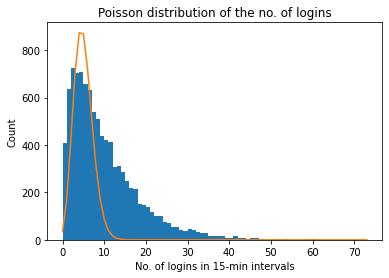

In [329]:
plt.title("Poisson distribution of the no. of logins")
plt.hist(df, bins=df['count'].max())
plt.plot([A_opt*pois(l_opt,X) for X in x])
plt.xlabel('No. of logins in 15-min intervals')
plt.ylabel('Count');

### Other distributions

In [217]:
#pip install fitter
from fitter import Fitter #, get_common_distributions, get_distributions

C:\Users\Admin\anaconda3\lib\site-packages\pkg_resources\__init__.py:122: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


,sumsquare_error,aic,bic,kl_div
gamma,0.022635,1248.074686,-126992.984347,inf
lognorm,0.023100,1214.507508,-126793.888925,inf
burr,0.023913,1260.071811,-126446.062527,inf
beta,0.025168,1233.581019,-125945.404929,inf
norm,0.035357,2301.662067,-122636.829442,inf


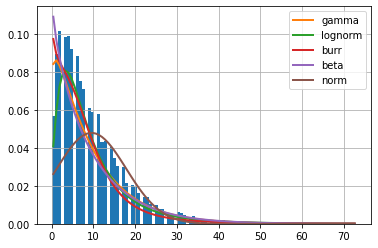

In [262]:
f = Fitter(df['count'].values,
           distributions=['gamma','lognorm','beta','burr','norm'],
           timeout=2000000)
f.fit()
f.summary()

Poisson is the most suitable distribution:

In [333]:
print(f"{A_opt}*pois({l_opt}, x)")

4950*pois(4.969999999999999, x)


Let's study the seasonality of the login counts.

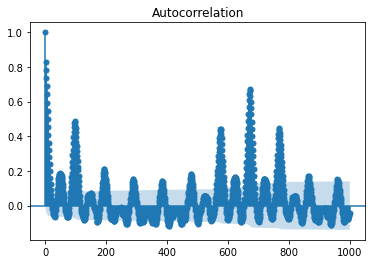

In [366]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['count'].values, lags=1000, alpha=0.05); # x - Series or Array, lags - how many lags of ACF will be plotted, alpha - significance level, determines the width of the confidence interval

From ACF plot, we observe weekly ($7*24*4 = 672$ time periods) and daily ($24*4 = 96$) seasonality.

## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

Availability of driver partners in a certain city depends on their circadian rhythm: On weekdays, only one city is active during the day or night, hence the driver partners tend to be from the same city. On weekends, there should be approximately the same proportion of driver partners from both cities. The key measure of success would be the value of the proportion of drivers from one of the two cities. If this proportion tends to 0.5, then the experiment is successfull.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

Some time after the start of the experiment, I'd start conducting periodic measurements of the proportion, $p_{2}$, of the drivers from one of the two cities. I'd repeat measurements once a week until the metric of a corresponding statistical test stops changing significantly, plus a few more measurements for extra verification.

b) what statistical test(s) you will conduct to verify the significance of the observation.

I'd conduct a pairwise z-test with Bonferroni's correction to determine if the proportion $p_{2}$ has changed compared to before experiment, $p_{1}$. The null and alternative hypotheses of the pairwise test are

$$H_{0} : p_{1} - p_{2} = 0 \\ H_{1} : p_{1} - p_{2} \neq 0$$

The measure of the difference between the two proportions is z-score:
$$z = \dfrac{(p_1 - p_2)}{\sqrt{\dfrac{p_1 \cdot (1-p_1)}{n_1} + \dfrac{p_2 \cdot (1-p_2)}{n_2} }}$$
where the denominator is the pooled variance, which is the sum of the two variances.
Bonferroni's correction is required to avoid the problem of growing probability to commit type I error just by chance due to repeated measurements. The significance level of a subsequent pairwise test would be taken as original significance level (0.05) divided by the sequential number of the current test. E.g., when conducting the 5th test, we'd use the significance level $\alpha = 0.05/5 = 0.01$.

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

If absolute value of the z-score is greater than the critical z-score, $z_{c}$, for a current value of the significance level (e.g., for $\alpha = 0.05, z_{c} = 1.96$), then the two proportions before and after experiment are significantly different. Once this happens, we can claim that the experiment is successfull.
From the repeated z-tests we can find out when we can start seeing a change in the proportion of drivers from the two cities, and eventually what is the final stabilized proportion.

## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [124]:
with open('ultimate_data_challenge.json', 'r') as json_file:
    df = pd.DataFrame(json.load(json_file)) # Time series (column of timestamp strings)
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


### Data Cleaning
#### Missing values

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Let's see if the 'avg_rating_of_driver' and 'avg_rating_by_driver' are correlated.

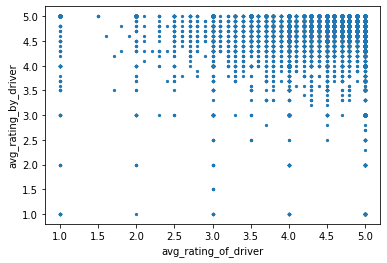

In [126]:
plt.scatter(df['avg_rating_of_driver'], df['avg_rating_by_driver'], s=5)
plt.xlabel('avg_rating_of_driver')
plt.ylabel('avg_rating_by_driver');

No, both ratings are scattered. Let's see if there is a correlation in the mean values. We shall take the mean value of the 'avg_rating_of_driver' on y-axis for each of the values of 'avg_rating_by_driver' on x-axis.

In [127]:
ratings = df[['avg_rating_of_driver','avg_rating_by_driver']]
ratings.head(2)

,avg_rating_of_driver,avg_rating_by_driver
0,4.7,5.0
1,5.0,5.0


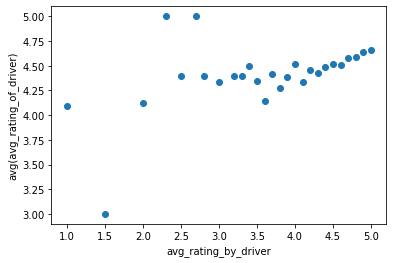

In [128]:
ratings_grp = ratings.groupby(by='avg_rating_by_driver', axis=0, as_index=False, sort=True, group_keys=True, dropna=True).mean()
plt.scatter(x='avg_rating_by_driver', y='avg_rating_of_driver', data=ratings_grp)
plt.xlabel('avg_rating_by_driver')
plt.ylabel('avg(avg_rating_of_driver)');

There is a linear increase trend. Using linear regression,

In [129]:
#define response variable
y = ratings_grp['avg_rating_of_driver'] # 'avg_rating_of_driver' averaged within a group of same 'avg_rating_by_driver'
#define explanatory variable
x = ratings_grp['avg_rating_by_driver']
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_rating_of_driver   R-squared:                       0.201
Model:                              OLS   Adj. R-squared:                  0.169
Method:                   Least Squares   F-statistic:                     6.291
Date:                  Wed, 09 Mar 2022   Prob (F-statistic):             0.0190
Time:                          13:40:22   Log-Likelihood:                -6.4599
No. Observations:                    27   AIC:                             16.92
Df Residuals:                        25   BIC:                             19.51
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


we find that both the slope and intercept values are non-zero (p-value is 0.019 for the slope and less than 0.001 for the intercept), so that there is a linear dependence

        avg(avg_rating_of_driver) = 3.8754 + 0.1493*avg_rating_by_driver

which we can use to fill out many missing values of 'avg_rating_of_driver'.     

Repeating the linear regression for the swapped variables x and y,

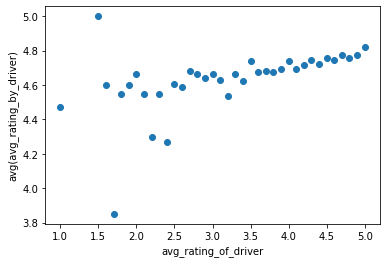

In [130]:
ratings_grp2 = ratings.groupby(by='avg_rating_of_driver', axis=0, as_index=False, sort=True, group_keys=True, dropna=True).mean()
plt.scatter(x='avg_rating_of_driver', y='avg_rating_by_driver', data=ratings_grp2)
plt.xlabel('avg_rating_of_driver')
plt.ylabel('avg(avg_rating_by_driver)');

There is a strong linear increase trend.

In [131]:
#define response variable
y = ratings_grp2['avg_rating_by_driver'] # 'avg_rating_by_driver' averaged within a group of same 'avg_rating_of_driver'
#define explanatory variable
x = ratings_grp2['avg_rating_of_driver']
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_rating_by_driver   R-squared:                       0.262
Model:                              OLS   Adj. R-squared:                  0.241
Method:                   Least Squares   F-statistic:                     12.43
Date:                  Wed, 09 Mar 2022   Prob (F-statistic):            0.00120
Time:                          13:40:32   Log-Likelihood:                 15.878
No. Observations:                    37   AIC:                            -27.76
Df Residuals:                        35   BIC:                            -24.53
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


we find that both the slope and intercept values are non-zero (p-value is 0.001 for the slope and even less for the intercept), so that there is a linear dependence

        avg(avg_rating_by_driver) = 4.3577 + 0.0863*avg_rating_of_driver

which we can use to fill out some of the missing values of 'avg_rating_by_driver'.

In [132]:
# Imputation of 'avg_rating_of_driver'
print(f"Of total {df['avg_rating_of_driver'].isnull().sum()} missing values of 'avg_rating_of_driver', we can impute \
{(df['avg_rating_of_driver'].isnull() & df['avg_rating_by_driver'].notnull()).sum()}.")
df.loc[df['avg_rating_of_driver'].isnull() & df['avg_rating_by_driver'].notnull(), 'avg_rating_of_driver'] =\
    3.8754 + 0.1493*df.loc[df['avg_rating_of_driver'].isnull() & df['avg_rating_by_driver'].notnull(), 'avg_rating_by_driver']

Of total 8122 missing values of 'avg_rating_of_driver', we can impute 8055.


In [133]:
# Imputation of 'avg_rating_by_driver'
print(f"Of total {df['avg_rating_by_driver'].isnull().sum()} missing values of 'avg_rating_by_driver', we can impute \
{(df['avg_rating_by_driver'].isnull() & df['avg_rating_of_driver'].notnull()).sum()}.")
df.loc[df['avg_rating_by_driver'].isnull() & df['avg_rating_of_driver'].notnull(), 'avg_rating_by_driver'] =\
    4.3577 + 0.0863*df.loc[df['avg_rating_by_driver'].isnull() & df['avg_rating_of_driver'].notnull(), 'avg_rating_of_driver']

Of total 201 missing values of 'avg_rating_by_driver', we can impute 134.


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    49933 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49933 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [135]:
df = df.dropna()
df.shape

(49539, 12)

In [136]:
# dates from string to datatetimes
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49539 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49539 non-null  object        
 1   trips_in_first_30_days  49539 non-null  int64         
 2   signup_date             49539 non-null  datetime64[ns]
 3   avg_rating_of_driver    49539 non-null  float64       
 4   avg_surge               49539 non-null  float64       
 5   last_trip_date          49539 non-null  datetime64[ns]
 6   phone                   49539 non-null  object        
 7   surge_pct               49539 non-null  float64       
 8   ultimate_black_user     49539 non-null  bool          
 9   weekday_pct             49539 non-null  float64       
 10  avg_dist                49539 non-null  float64       
 11  avg_rating_by_driver    49539 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

C:\Users\Admin\AppData\Local\Temp/ipykernel_11112/770417948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signup_date'] = pd.to_datetime(df['signup_date'])
C:\Users\Admin\AppData\Local\Temp/ipykernel_11112/770417948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])


In [137]:
df['city'].value_counts()

Winterfell        23092
Astapor           16402
King's Landing    10045
Name: city, dtype: int64

To do not introduce an artificial relationship between cities, the 'city' has to be one-hot-encoded (not label-encoded).

In [ ]:
df['phone'].value_counts()

In [138]:
# One-hot encoding based on data type
df = pd.get_dummies(df, drop_first=False, columns=df.select_dtypes(include='object').columns)

In [142]:
df['ultimate_black_user'].value_counts()

False    30939
True     18600
Name: ultimate_black_user, dtype: int64

Binary variable 'ultimate_black_user' can be label-encoded.

In [144]:
df[['ultimate_black_user']]=df[['ultimate_black_user']].apply(LabelEncoder().fit_transform)

In [145]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,1,1,0


To determine if the user is retained, we take the latest available 'last_trip_date' as a current date (when a prediction has to be made) and then see if the user is active (took a ride in the last 30 days).

In [151]:
today = df['last_trip_date'].max()
thirty_days_ago = today - pd.Timedelta(days=30)
print("Today:", today.strftime('%Y-%m-%d'))
print("30 days ago:", thirty_days_ago.strftime('%Y-%m-%d'))

Today: 2014-07-01
30 days ago: 2014-06-01


In [158]:
# Label: 1 - churn, 0 - active
df['churn'] = 0
df.loc[df['last_trip_date'] < thirty_days_ago, 'churn'] = 1
print(f"Proportion of churn as of {today.strftime('%Y-%m-%d')}: {df['churn'].sum()/len(df)}")

Proportion of churn as of 2014-07-01: 0.6235491229132603


### Train-Test Split
We take 30% of data for testing of the trained ML model.

In [188]:
# Full dataset for 6 months
X = df.drop(['churn','signup_date','last_trip_date'], axis=1)
y=df['churn']

In [189]:
# Train-test split first:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 34677
Test samples: 14862


### Correlation matrix

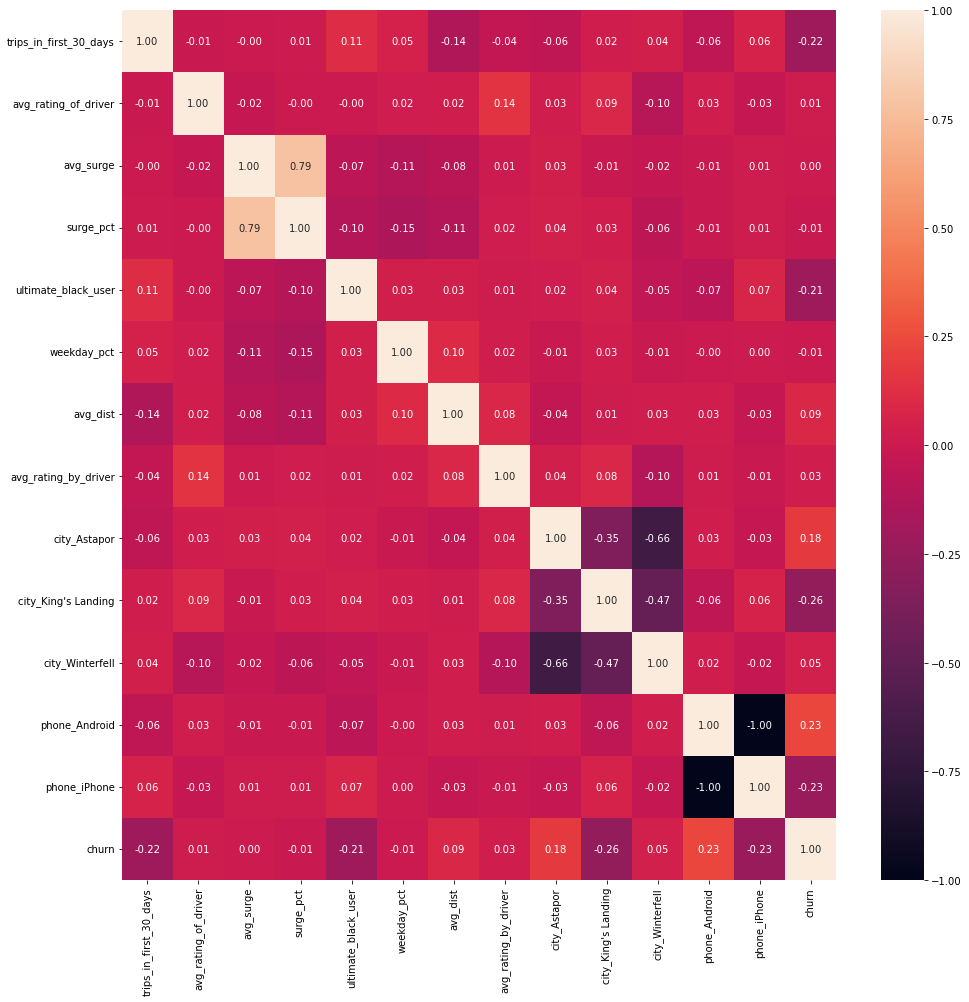

In [190]:
# Correlation matrix
plt.subplots(figsize=(16,16))
corr = X_train.join(y_train).corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

The features with larger absolute values of correlation with 'churn' are expected to be more important:

In [191]:
corr['churn'].apply(abs).sort_values(ascending=False)

churn                     1.000000
city_King's Landing       0.263549
phone_iPhone              0.228426
phone_Android             0.228426
trips_in_first_30_days    0.216207
ultimate_black_user       0.207402
city_Astapor              0.176650
avg_dist                  0.093219
city_Winterfell           0.045729
avg_rating_by_driver      0.028761
surge_pct                 0.014320
avg_rating_of_driver      0.009980
weekday_pct               0.006591
avg_surge                 0.003214
Name: churn, dtype: float64

### ML model

In [212]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

pca = PCA(n_components=2, whiten=True).fit(X_train)
X_pca = pca.transform(X)


def visualize_tree(classifier, X, y, boundaries=True,xlim=None, ylim=None):
    '''
    Visualizes a Decision Tree. 
    INPUTS: Classifier Model, X, y, optional x/y limits.
    OUTPUTS: Meshgrid visualization for boundaries (boolean) of the Decision Tree
    Adapted from https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/helpers_05_08.py
    '''
     
    # Fit the X and y data to the tree
    classifier.fit(X, y)

    
    # Automatically set the x and y limits to the data (+/- 0.1)
    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    # Assign the variables
    x_min, x_max = xlim
    y_min, y_max = ylim
    
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Define the Z by the predictions (this will be a color in the mesh grid)
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # Reshape based on meshgrid
    Z = Z.reshape(xx.shape)
    
    # Plot the figure (use)
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='jet')
    

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet') # red - churn
    
    #Set Limits
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    
    def plot_boundaries(i, xlim, ylim):
        '''
        Plots the Decision Boundaries
        '''
        if i < 0:
            return

        # Shorter variable name
        tree = classifier.tree_
        
        # Recursively go through nodes of tree to plot boundaries.
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
    
    # Random Forest vs Single Tree
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

In [ ]:
def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm, cmap=plt.cm.YlGn) #ax.imshow(cm, cmap=plt.cm.Greens)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0', 'Predicted 1'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Loyal 0', 'Churn 1'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, round(cm[i, j],3), ha='center', va='center', color='black', size=15) # counts
    plt.show();
    return tn,fp,fn,tp

def scores_all(X_test, y_test, model, prnt=False):
    '''Quality metrics: roc_auc, accuracy, tnr, tpr, precision, f1, MCC. Inputs: X_test, y_test, model'''
    y_score = model.predict_proba(X_test)[:,1] # predicted probabilities of y=1
    y_pred = model.predict(X_test) # predicted labels 0,1
    cm = confusion_matrix(y_test, y_pred)
    global tn, fp, fn, tp
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    
    roc_auc = roc_auc_score(y_test, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    if prnt == True:
        dr = 6 # rounding digits
        print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
        print(f"%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
    return roc_auc, accuracy, tnr, tpr, precision, f1, MCC;

In [370]:
?RandomForestClassifier

Accuracy in training: 0.8283876921302304
Accuracy in testing:
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.844734	0.777890	0.662710	0.848432	0.804196	0.825722	0.521614
[[TN, FP], [FN, TP]] =
 [[3741 1904]
 [1397 7820]]


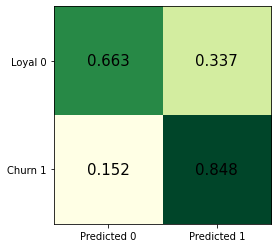

In [406]:
#clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0,criterion='gini', class_weight='balanced')
clf_rf = RandomForestClassifier(random_state=0, criterion='gini', max_depth=11, max_features=0.3, n_estimators=201,
                                class_weight={0:1, 1:0.90})
#criterion='gini',
# Remove boundaries to avoid error
#visualize_tree(clf_rf,X_pca,y.ravel(),boundaries=False)

clf_rf.fit(X_train, y_train.ravel())
print('Accuracy in training:',clf_rf.score(X_train, y_train.ravel()))
print('Accuracy in testing:')
roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, clf_rf, prnt=True)
y_pred = clf_rf.predict(X_test)
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)

In [397]:
print(clf_rf.class_weight, roc_auc)

{0: 1, 1: 0.85} 0.8444713157120133


In [405]:
print(clf_rf.class_weight, roc_auc)

{0: 1, 1: 0.89} 0.8446495591530765


In [387]:
print(clf_rf.class_weight, roc_auc)

{0: 1, 1: 0.9} 0.8447342411243214


In [403]:
print(clf_rf.class_weight, roc_auc)

{0: 1, 1: 0.91} 0.8445671162761688


In [407]:
print('Cross Validation Scores:')
scores = cross_val_score(clf_rf, X_train, y_train.ravel(), cv=10)

print(scores)
print("Mean CV accuracy:",np.mean(scores))
print("STD of CV accuracy:",np.std(scores))

Cross Validation Scores:
[0.78719723 0.78806228 0.78950404 0.79901961 0.78546713 0.79094579
 0.78979239 0.77761754 0.7773291  0.78309778]
Mean CV accuracy: 0.7868032884780509
STD of CV accuracy: 0.006115734986602247


|Optimization|criterion|max_features|max_depth|n_estimators|class_weight|ROC AUC |Accuracy|TNR     |TPR     |Precision|F1      |MCC     | Accuracy CV|STD Accuracy CV|
|:-----------|:-------:|:----------:|:-------:|:----------:|:------:|:------:|:------:|:------:|:------:|:-------:|:------:|:------:|:------:|:------:|
|Default     |gini*    |auto = 0.3*|None|None=1    |100|0.817683|0.749361|0.658636|0.804926|0.793816|0.799332|0.465703|0.758889|0.004598|
|max_depth   |gini     |0.3   |11      |100|1|0.844113|0.775939|0.640213|0.859065|0.795859|0.826255|0.515117|0.786573|0.006251|
|n_estimators|gini     |0.3   |11      |201|1|0.844433|0.776881|0.644110|0.858197|0.797459|0.826714|0.517448|0.787611|0.006367|
|class_weight|gini     |0.3   |11      |201|0.90|0.844734|0.777890|0.662710|0.848432|0.804196|0.825722|0.521614|0.786803|0.006116|

In all runs, 'random_state'=0 and the cross-validation is 10-fold. Asterisk indicates that optimization of this hyperparameter alone does not change it.

### Feature importance

Feature ranking:


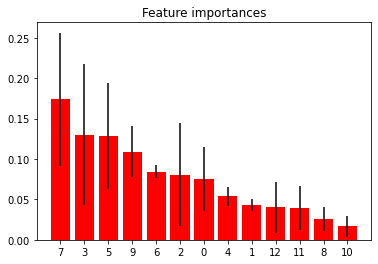

,features,importance
7,avg_rating_by_driver,0.173954
3,surge_pct,0.130260
5,weekday_pct,0.128038
9,city_King's Landing,0.108729
6,avg_dist,0.084057
2,avg_surge,0.080736
0,trips_in_first_30_days,0.075191
4,ultimate_black_user,0.053696
1,avg_rating_of_driver,0.042998
12,phone_iPhone,0.040257


In [299]:
importFeature = clf_rf.feature_importances_
feature_importances=pd.DataFrame([importFeature])

std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],axis=0)
indices = np.argsort(importFeature)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importFeature[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

col_names = X_train.columns
feature_importances=pd.DataFrame(pd.Series(col_names)[indices])
feature_importances['importance']=np.sort(importFeature)[::-1]
feature_importances.columns=['features','importance']
feature_importances

In [217]:
corr['churn'].sort_values(ascending=False)

churn                     1.000000
phone_Android             0.228426
city_Astapor              0.176650
avg_dist                  0.093219
city_Winterfell           0.045729
avg_rating_by_driver      0.028761
avg_rating_of_driver      0.009980
avg_surge                 0.003214
weekday_pct              -0.006591
surge_pct                -0.014320
ultimate_black_user      -0.207402
trips_in_first_30_days   -0.216207
phone_iPhone             -0.228426
city_King's Landing      -0.263549
Name: churn, dtype: float64

### Conclusion
1) As of 2014-07-01, the proportion of churn is 0.6235.

2) I applied the Random Forest model, based on its high performance in my previous project on customer churn prediction. It remains to optimize the hyperparameters of the model. The key indicators are: <b>ROC AUC = 0.844734, Accuracy = 0.777890</b>. Mean CV accuracy is 0.786803, and the standard deviation is 0.006116.

3) The most influential feature is the 'avg_rating_by_driver'. Since it is positively correlated with the 'churn' label, the larger this feature is, the larger is the churn probability. Next in importance is 'surge_pct' (the percent of trips taken with surge multiplier > 1), which is negatively correlated with 'churn' label: the higher it is, the lower is the churn probability. The same is true for the third in importance feature 'weekday_pct' (the percent of the user’s trips occurring during a weekday).

Therefore, the Ultimate should focus on the passengers with higher average rating by driver, as well as lower 'surge_pct' and 'weekday_pct'.